In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore")

In [2]:
#downloading the dataset for beans and splitting it into train,test and validation
datasets, info =tfds.load(name='cassava',with_info=True,as_supervised=True,split=['train','test','validation'])

Shuffling and writing examples to /root/tensorflow_datasets/cassava/0.1.0.incompleteMDE25J/cassava-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cassava/0.1.0.incompleteMDE25J/cassava-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cassava/0.1.0.incompleteMDE25J/cassava-validation.tfrecord


Dataset cassava downloaded and prepared to /root/tensorflow_datasets/cassava/0.1.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='cassava',
    version=0.1.0,
    description='Cassava consists of leaf images for the cassava plant depicting healthy and
four (4) disease conditions; Cassava Mosaic Disease (CMD), Cassava Bacterial
Blight (CBB), Cassava Greem Mite (CGM) and Cassava Brown Streak Disease (CBSD).
Dataset consists of a total of 9430 labelled images.
The 9430 labelled images are split into a training set (5656), a test set(1885)
and a validation set (1889). The number of images per class are unbalanced with
the two disease classes CMD and CBSD having 72% of the images.',
    homepage='https://www.kaggle.com/c/cassava-disease/overview',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=9430,
    splits={
        'test': 1885,
        'train': 5656,
        'validation': 1889,
 

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


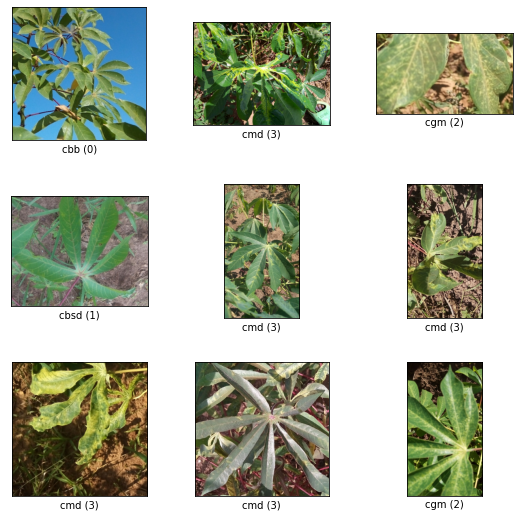

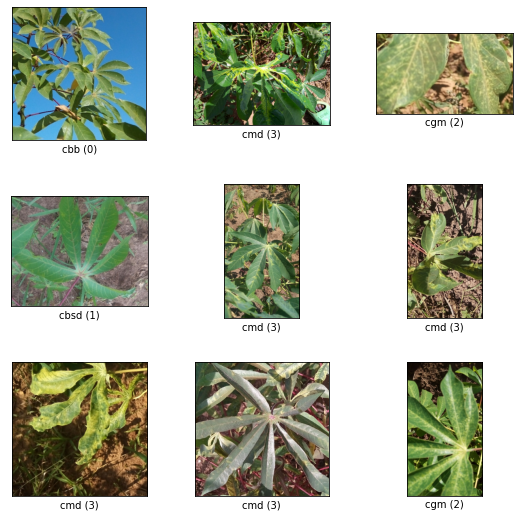

In [4]:
train,info_train =tfds.load(name='cassava',with_info=True,split='test')
tfds.show_examples(info_train,train)

In [5]:
#scaling the data so that the pixels can fit

def scale(image,label):
  image=tf.cast(image,tf.float32)
  image /=2555.0
  return tf.image.resize(image,[224,224]),tf.one_hot(label,3)

In [6]:
#function to batch the data
def get_dataset(batch_size=32):
  train_dataset_scaled=datasets[0].map(scale).shuffle(1000).batch(batch_size)
  test_dataset_scaled=datasets[1].map(scale).batch(batch_size)
  val_dataset_scaled=datasets[2].map(scale).batch(batch_size)
  return train_dataset_scaled,test_dataset_scaled,val_dataset_scaled

In [7]:
train_dataset,test_dataset,val_dataset= get_dataset()
train_dataset.cache()
val_dataset.cache()

<CacheDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [8]:
#length of the train dataset
len(list(datasets[0]))

5656

In [9]:
#downloading a pre trained model
feature_extractor="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"


In [10]:
feature_extractor_layer=hub.KerasLayer(feature_extractor,input_shape=(224,224,3))

In [11]:
#training the last layer
feature_extractor_layer.trainable=False

In [12]:
model=tf.keras.Sequential([feature_extractor_layer,tf.keras.layers.Dropout(0.3),
                           tf.keras.layers.Dense(3,activation='softmax')]
    
)#drop 30% of the weights
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['acc'])

In [14]:
history=model.fit(train_dataset,epochs=6,validation_data=val_dataset)

Epoch 1/6
177/177 [==============================] - 238s 1s/step - loss: 0.4918 - acc: 0.2853 - val_loss: 0.3960 - val_acc: 0.3097
Epoch 2/6
177/177 [==============================] - 235s 1s/step - loss: 0.4265 - acc: 0.3292 - val_loss: 0.3674 - val_acc: 0.3346
Epoch 3/6
177/177 [==============================] - 234s 1s/step - loss: 0.3895 - acc: 0.3368 - val_loss: 0.3616 - val_acc: 0.3526
Epoch 4/6
177/177 [==============================] - 233s 1s/step - loss: 0.3929 - acc: 0.3471 - val_loss: 0.3570 - val_acc: 0.3399
Epoch 5/6
177/177 [==============================] - 234s 1s/step - loss: 0.3749 - acc: 0.3542 - val_loss: 0.3454 - val_acc: 0.3610
Epoch 6/6
177/177 [==============================] - 233s 1s/step - loss: 0.3602 - acc: 0.3676 - val_loss: 0.3448 - val_acc: 0.3563


In [15]:
result=model.evaluate(test_dataset)

59/59 [==============================] - 59s 988ms/step - loss: 0.3682 - acc: 0.3374


In [ ]:
for test_sample in datasets[1].take(10):
  image,label=test_sample[0],test_sample[1]
  image_scaled,image_arr=scale(test_sample[0],test_sample[1])
  image_scaled =np.expand_dims(image_scaled,axis=0)
  img=tf.keras.preprocessing.image.img_to_array(image)
  pred=model.predict(image_scaled)
  print(pred)
  plt.figure()
  plt.imshow(image)
  plt.show()
  print("Actual label: %s" % info.features['label'].names[label.numpy()])
  print("predicted label: %s" % info.features['label'].names[np.argmax(pred)])

In [23]:
for f0,f1 in datasets[1].map(scale).batch(200):
  y=np.argmax(f1,axis=1)
  y_pred=np.argmax(model.predict(f0),axis=1)
  print(tf.math.confusion_matrix(labels=y,predictions=y_pred,num_classes=3))

tf.Tensor(
[[ 6 76 45]
 [ 2 42  4]
 [ 2  7 16]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[10 62 52]
 [ 9 39  3]
 [ 1  5 19]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[ 6 62 39]
 [ 3 51  6]
 [ 1 15 17]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[ 8 69 38]
 [ 3 47  3]
 [ 4  8 20]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[12 67 48]
 [ 2 46  2]
 [ 2  6 15]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[ 6 54 61]
 [ 4 50  2]
 [ 2  8 13]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[11 65 49]
 [ 2 36  4]
 [ 0 20 13]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[ 7 66 45]
 [ 4 43  4]
 [ 2  8 21]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[12 68 44]
 [ 0 45  4]
 [ 0 11 16]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[ 1 30 27]
 [ 4 13  4]
 [ 0  3  3]], shape=(3, 3), dtype=int32)


In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(train_dataset,epochs=2,
          validation_data=(val_dataset),
          callbacks=[cp_callback])  #

In [ ]:
ls {checkpoint_dir}

In [20]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(val_dataset, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

60/60 - 58s - loss: 0.3350 - acc: 0.3663
Restored model, accuracy: 36.63%


In [ ]:

print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [22]:
model.save('my_model.pkl')
# This will save the model in your file system. Alternatively you can use pickle or joblib.

INFO:tensorflow:Assets written to: my_model.pkl/assets


INFO:tensorflow:Assets written to: my_model.pkl/assets
